# Create initial condition fields for Mn

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import datetime
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import glob
from math import isclose
import pickle
import xarray as xr

%matplotlib inline

### Load Marco Van Hulten's model output:

In [2]:
folder = '/ocean/brogalla/GEOTRACES/data/van_hulten/'
file = 'Fmang-16B05-LD40_Bio_1y_ptrc_T_P80.nc' #Fmang-16B05-LD40_Bio_1y_diad_T_P80.nc 

In [3]:
global_Mn = nc.Dataset(folder+file)

global_mn_dis = np.array(global_Mn.variables['dMn'])[0,:,:,:] # time, deptht, y, x
global_mn_oxi = np.array(global_Mn.variables['oMn'])[0,:,:,:]
global_depths = np.array(global_Mn.variables['deptht'])
global_time   = np.array(global_Mn.variables['time'])
global_lats   = np.array(global_Mn.variables['nav_lat'])
global_lons   = np.array(global_Mn.variables['nav_lon'])

In [4]:
mesh  = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
ANHA12_lons     = np.array(mesh.variables['nav_lon'])
ANHA12_lats     = np.array(mesh.variables['nav_lat'])
ANHA12_z_levels = np.array(mesh.variables['nav_lev'])
ANHA12_tmask    = np.array(mesh.variables['tmask'])
ANHA12_Z_masked = np.ma.masked_where((ANHA12_tmask[0,0,:,:] > 0.1), ANHA12_tmask[0,0,:,:]) 

In [5]:
def plot_variable(lons, lats, variable, label='', depth_level=0, v=(0,1)):

    fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-reference.pickle','rb'))

    x, y   = proj1(lons, lats) 
    CB     = proj1.pcolormesh(x, y, variable[depth_level,:,:]*1e9, vmin=v[0], vmax=v[1])
    
    cbaxes = fig.add_axes([0.2, 0.22, 0.02, 0.2]) 
    CBar1  = plt.colorbar(CB, ax=ax1, cax=cbaxes, orientation='vertical')
    CBar1.ax.tick_params(labelsize=5) 
    ax1.set_title(label, fontsize=6)

    return

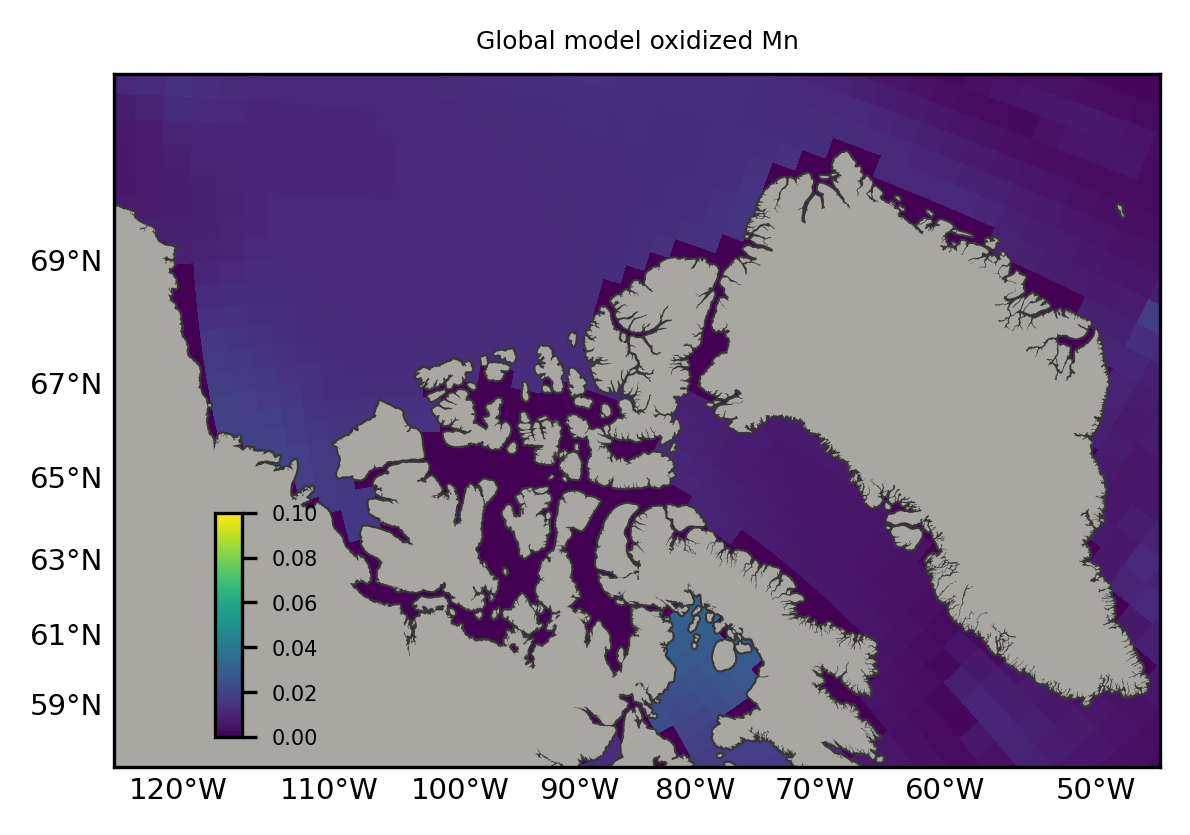

In [7]:
plot_variable(global_lons, global_lats, global_mn_oxi, v=(0,0.1), label='Global model oxidized Mn')

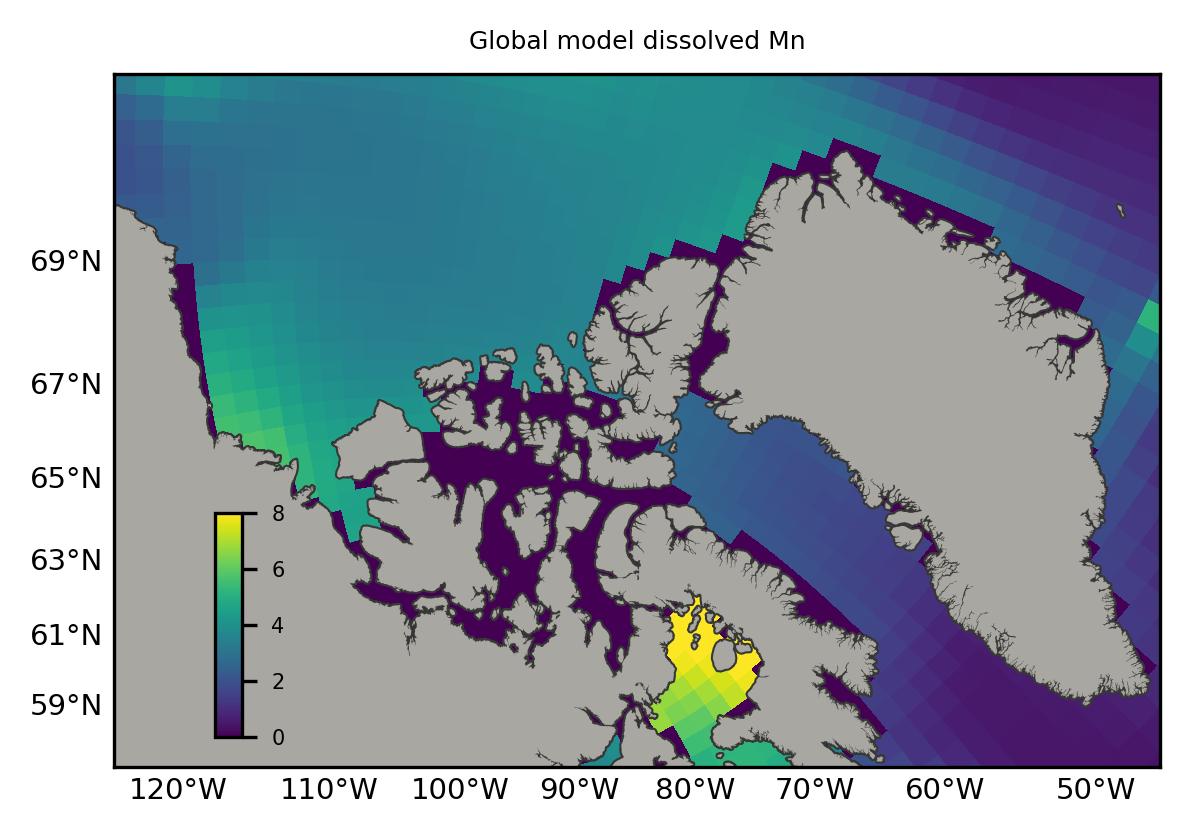

In [8]:
plot_variable(global_lons, global_lats, global_mn_dis, v=(0,8), label= 'Global model dissolved Mn')

### Load ANHA12 fields to interpolate to:

In [6]:
m = nc.Dataset('/data/brogalla/ANHA12/ANHA12-EXH006_5d_gridT_y2002m01d05.nc')
mdepth = np.array(m.variables['deptht'])
mlons = np.array(m.variables['nav_lon'])
mlats = np.array(m.variables['nav_lat'])

### Interpolate from outer boundaries:

First interpolate with depth: depths --> mdepth

In [7]:
print('Original size: ' + str(global_depths.shape))
print('New size: ' + str(ANHA12_z_levels.shape))

Original size: (31,)
New size: (50,)


In [11]:
# # Default some background values
# global_mn_oxi[global_mn_oxi==0] = 1.0e-10
# global_mn_dis[global_mn_dis==0] = 1e-9
# global_mn_dis[30,93,34]         = 1e-9

In [8]:
for z,depth in enumerate(global_depths):
    if (np.mean(global_mn_dis[z,130:,50:][global_mn_dis[z,130:,50:]!=0] > 1e-7)) or \
            (np.mean(global_mn_oxi[z,130:,50:][global_mn_oxi[z,130:,50:]!=0]) > 1e-8):
        global_mn_oxi[z,:,:][global_mn_oxi[z,:,:]==0] = 1e-10
        global_mn_dis[z,:,:][global_mn_dis[z,:,:]==0] = 1e-9
    else: #[130:,50:]
        global_mn_oxi[z,:,:][global_mn_oxi[z,:,:]==0] = np.mean(global_mn_oxi[z,130:,50:][global_mn_oxi[z,130:,50:]!=0])
        global_mn_dis[z,:,:][global_mn_dis[z,:,:]==0] = np.mean(global_mn_dis[z,130:,50:][global_mn_dis[z,130:,50:]!=0])

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [9]:
def interp_depths(var, mdepth,fill):
    # constant extrapolation for values outside of the range
    from scipy import interpolate
    
    interp_var = np.empty((50, 149, 182))
    x = global_depths
    
    for i in range(0,149):
        for j in range(0,182):
            # interpolate over depths   
            f = interpolate.interp1d(global_depths, var[:,i,j], fill_value=fill) # fill_value = np.mean(var[:,i,j]))#fill)
            interp_var[:,i,j] = f(mdepth)
    return interp_var

In [10]:
i_mn_oxi = interp_depths(global_mn_oxi, ANHA12_z_levels, fill='extrapolate')
i_mn_dis = interp_depths(global_mn_dis, ANHA12_z_levels, fill='extrapolate')
i_mn_oxi = np.array(i_mn_oxi)
i_mn_dis = np.array(i_mn_dis)

In [34]:
i_mn_oxi[i_mn_oxi<0] = 1.0e-11
# i_mn_dis[i_mn_dis<3e-9] = 3e-9

Then spatially: lons --> mlons, lats --> mlats

In [35]:
def interp_np(nav_lon, nav_lat, var_in, lon_ANHA12, lat_ANHA12):
    ''' Interpolate Mn model output from Marco to ANHA12 grid.
        The function is based on the bilinear interpolation in scipy, griddata 
        =======================================================================
            nav_lon, nav_lat        : Mn model lons/lats
            lon_ANHA12, lat_ANHA12  : ANHA12 defined lons/lats
            var_in                  : 2-D Mn model variable
    '''
    from scipy.interpolate import griddata

    LatLonPair = (nav_lon.flatten(), nav_lat.flatten())
    var_out = griddata(LatLonPair, var_in.flatten(), (lon_ANHA12, lat_ANHA12), method='linear')
    # Take nearest neighbour interpolation to fill nans
    var_fill = griddata(LatLonPair, var_in.flatten(), (lon_ANHA12, lat_ANHA12), method='nearest')
    var_out[np.isnan(var_out)] = var_fill[np.isnan(var_out)]
    return var_out

In [36]:
ini_mn_oxi = np.empty((50, 2400, 1632))
ini_mn_dis = np.empty((50, 2400, 1632))

for i in range(0,50):
    ini_mn_oxi[i,:,:] = interp_np(global_lons, global_lats, i_mn_oxi[i,:,:], ANHA12_lons, ANHA12_lats)
    ini_mn_dis[i,:,:] = interp_np(global_lons, global_lats, i_mn_dis[i,:,:], ANHA12_lons, ANHA12_lats)

#### linear interpolation w. constant values filled in:

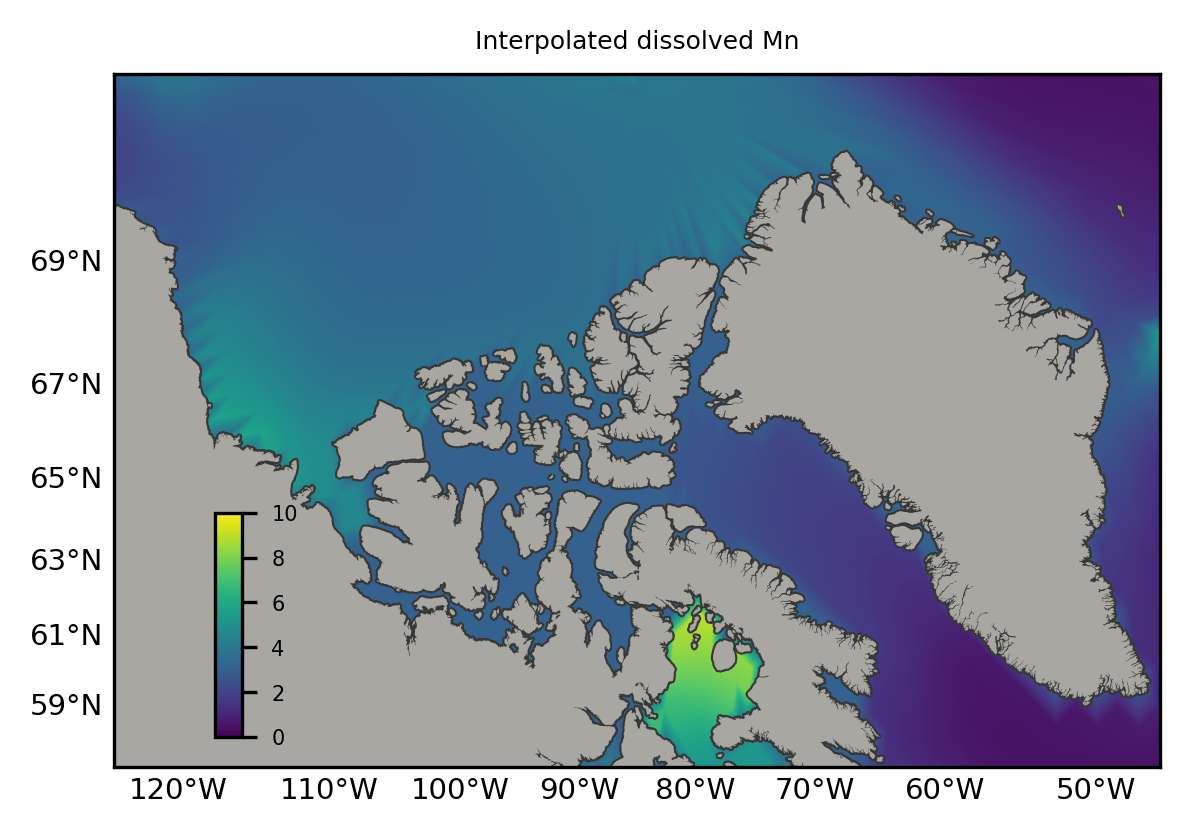

In [14]:
plot_variable(ANHA12_lons, ANHA12_lats, ini_mn_dis, 'Interpolated dissolved Mn', v=(0,10))

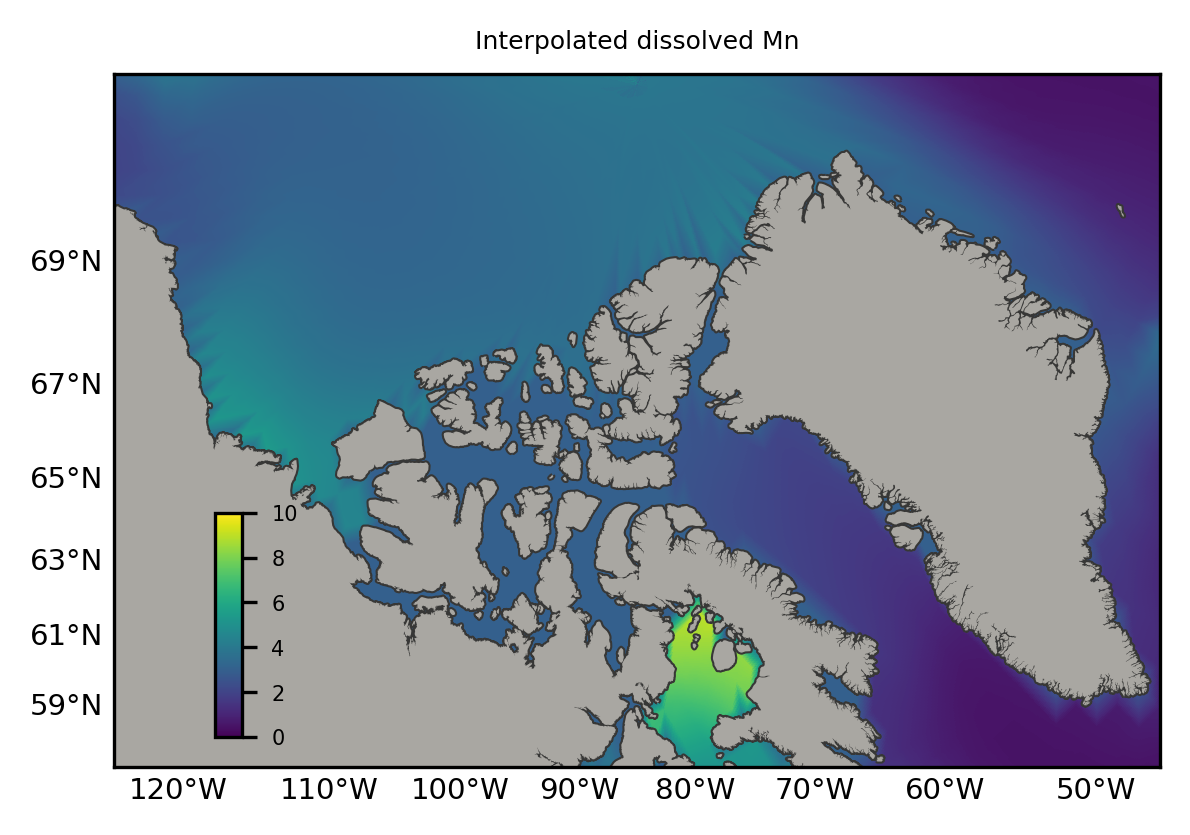

In [15]:
plot_variable(ANHA12_lons, ANHA12_lats, ini_mn_dis, 'Interpolated dissolved Mn', v=(0,10), depth_level=10)

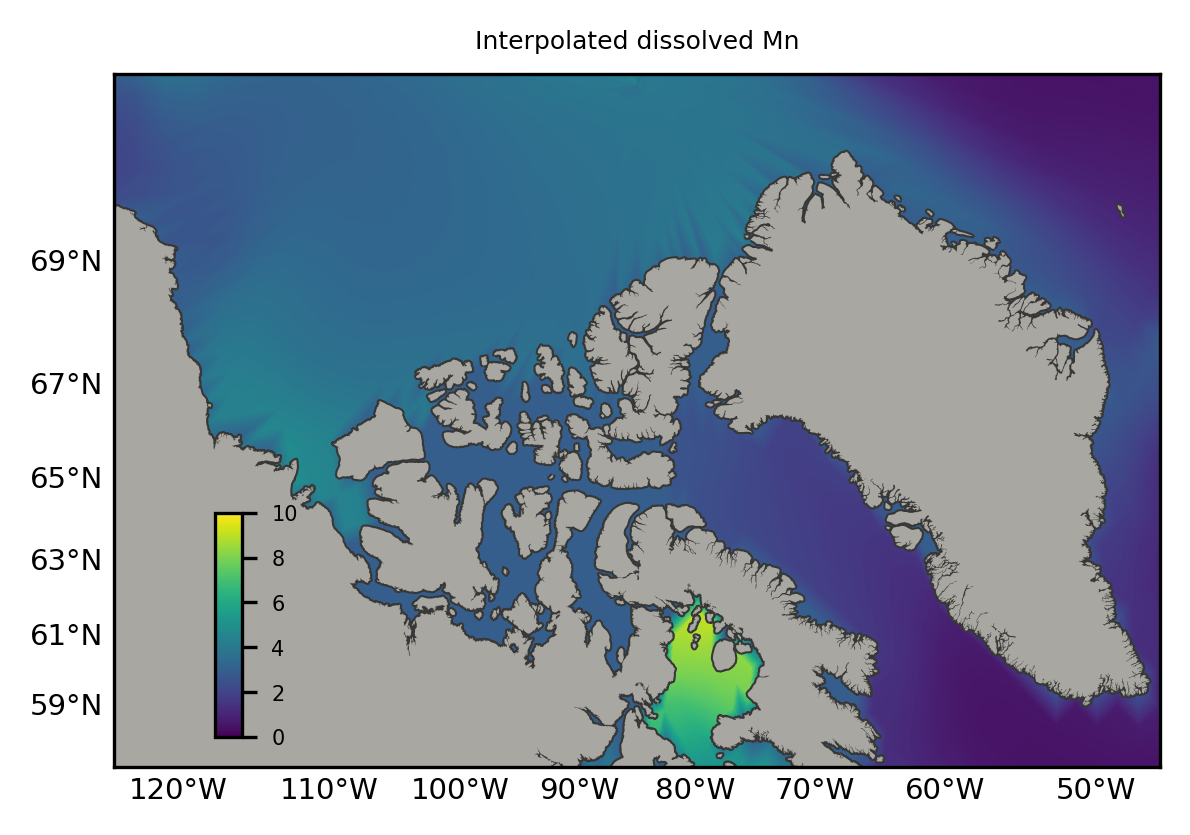

In [16]:
plot_variable(ANHA12_lons, ANHA12_lats, ini_mn_dis, 'Interpolated dissolved Mn', v=(0,10), depth_level=15)

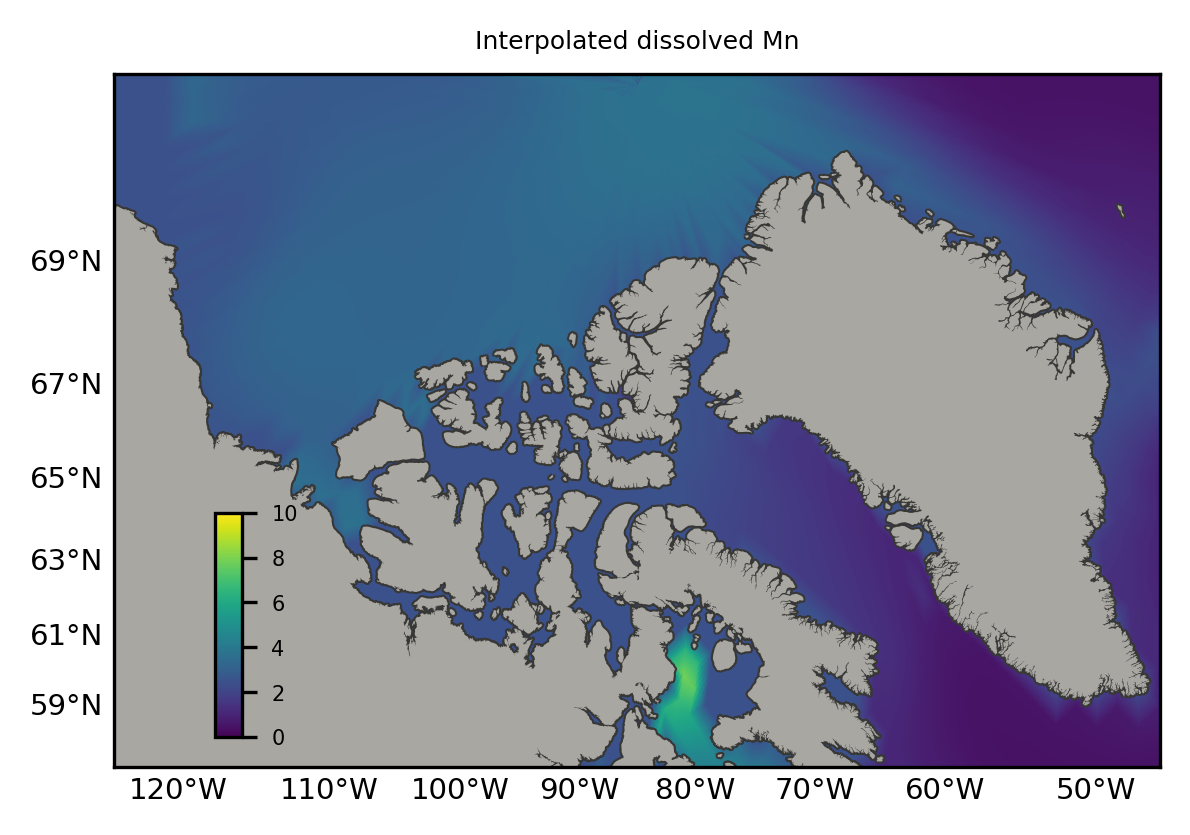

In [17]:
plot_variable(ANHA12_lons, ANHA12_lats, ini_mn_dis, 'Interpolated dissolved Mn', v=(0,10), depth_level=20)

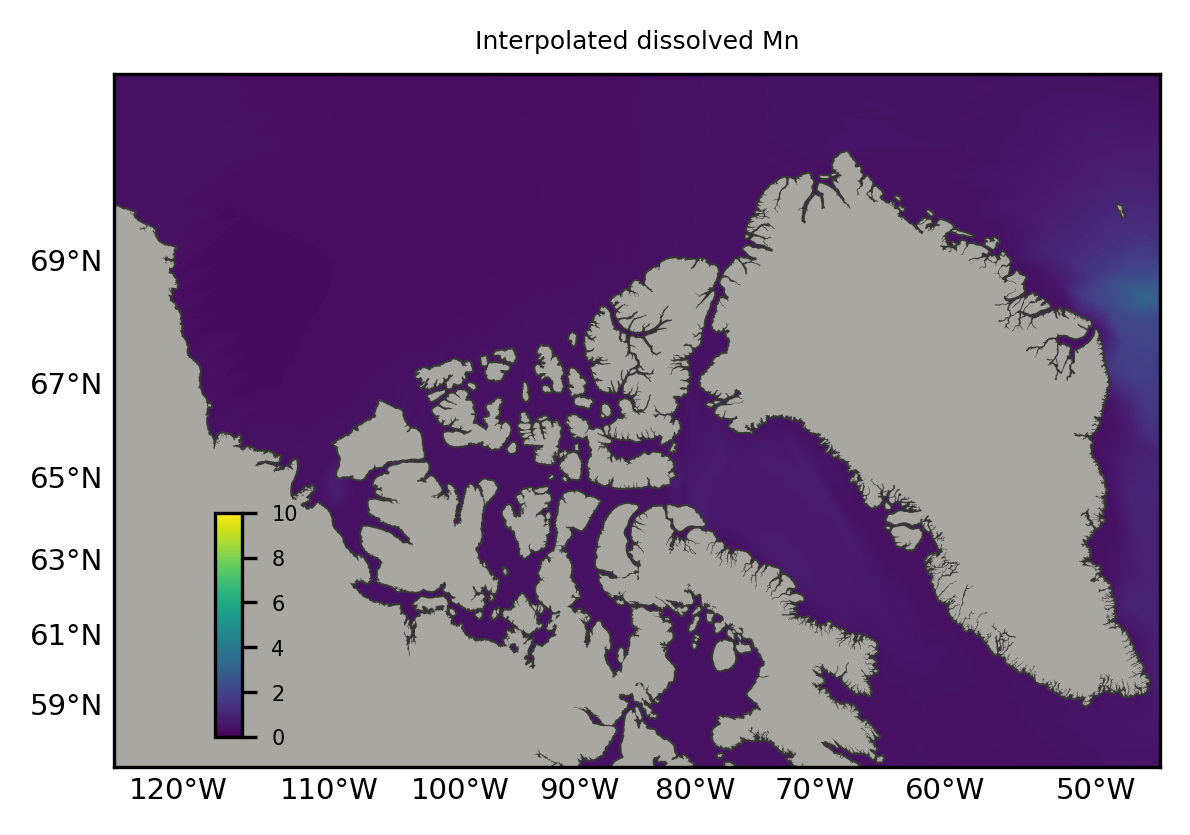

In [18]:
plot_variable(ANHA12_lons, ANHA12_lats, ini_mn_dis, 'Interpolated dissolved Mn', v=(0,10), depth_level=30)

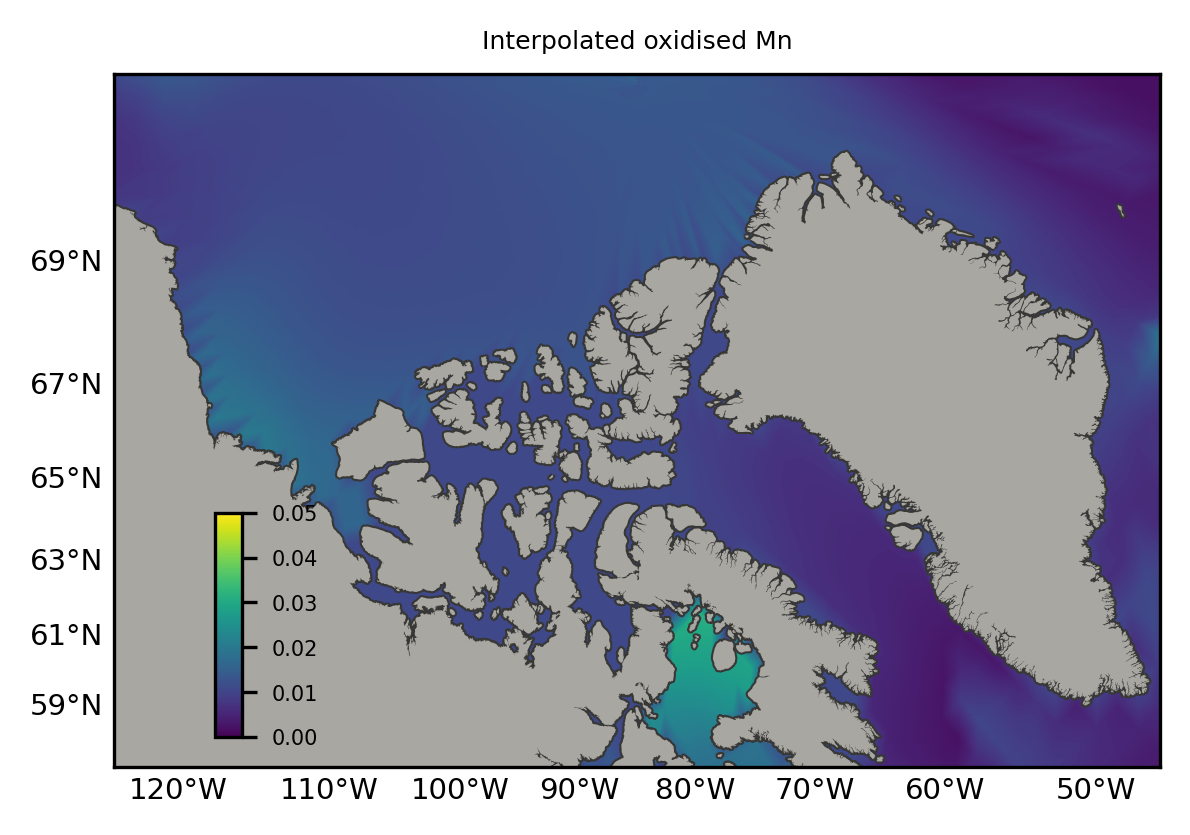

In [38]:
plot_variable(ANHA12_lons, ANHA12_lats, ini_mn_oxi, 'Interpolated oxidised Mn', v=(0,0.05))

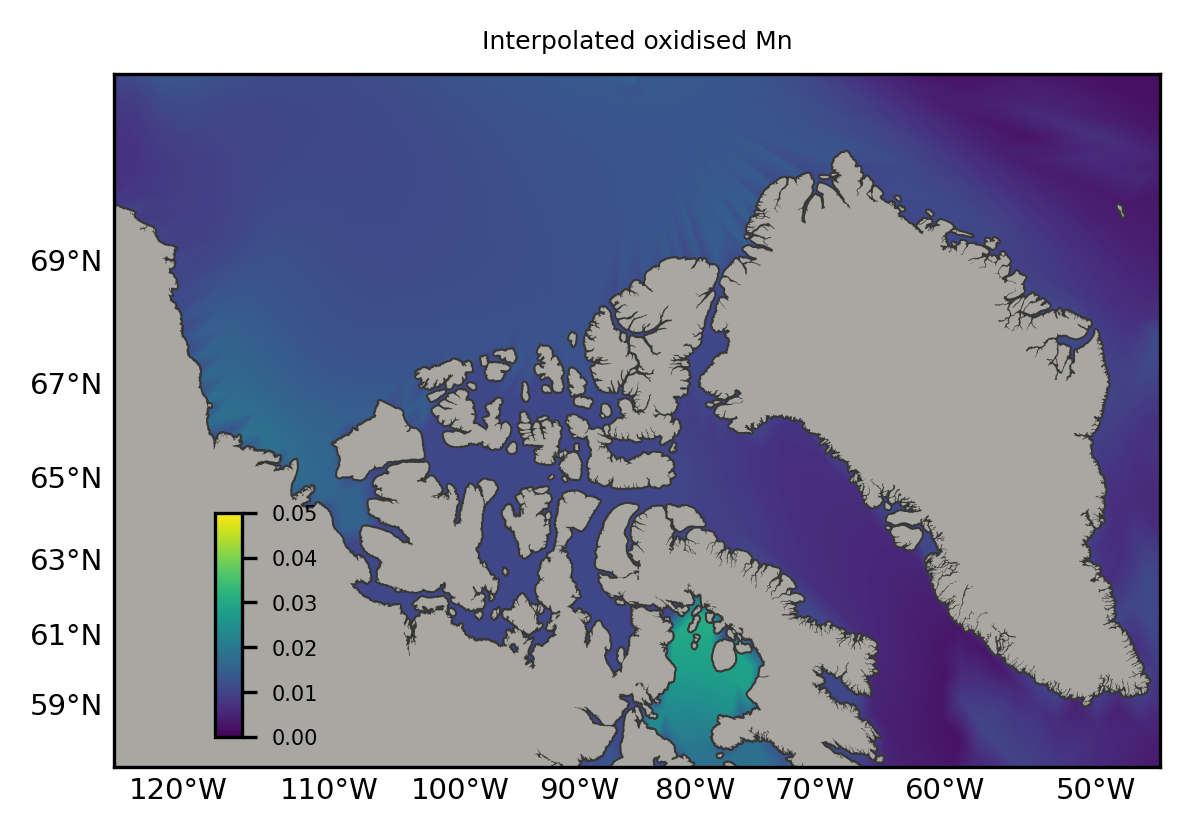

In [37]:
plot_variable(ANHA12_lons, ANHA12_lats, ini_mn_oxi, 'Interpolated oxidised Mn', v=(0,0.05), depth_level=10)

### Write NetCDF IC file:

In [44]:
dmn_var_ini = np.reshape(ini_mn_dis, (1,50,2400,1632))
omn_var_ini = np.reshape(ini_mn_oxi, (1,50,2400,1632))

In [46]:
print('Check values:')
print(f'NaN in dMn: {sum(sum(sum(sum(np.isnan(dmn_var_ini)))))}')
print(f'NaN in oMn: {sum(sum(sum(sum(np.isnan(omn_var_ini)))))}')
print(f'zeros in dMn: {sum(dmn_var_ini[dmn_var_ini<=0])}')
print(f'zeros in oMn: {sum(omn_var_ini[omn_var_ini<=0])}')
print(f'too large in dMn: {sum(dmn_var_ini[dmn_var_ini > 1])}')
print(f'too large in oMn: {sum(omn_var_ini[omn_var_ini > 1])}')

Check values:
NaN in dMn: 0
NaN in oMn: 0
zeros in dMn: 0
zeros in oMn: 0
too large in dMn: 0
too large in oMn: 0


In [47]:
file_write = xr.Dataset(
    {'dMn': (('time_counter','deptht','y','x'), dmn_var_ini),
     'oMn': (('time_counter','deptht','y','x'), omn_var_ini)}, 
     coords = {
         "deptht": ANHA12_z_levels,
         "y": np.zeros(2400),
         "x": np.zeros(1632),
    })
    
file_write.to_netcdf('/ocean/brogalla/GEOTRACES/data/Mn_ini_20210810.nc', unlimited_dims=['time_counter'])